In [ ]:
!pip install implicit

In [84]:
import numpy as np
import pandas as pd
import os
import implicit
from scipy.sparse import csr_matrix
import scipy.sparse as sparse
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm

In [85]:
USER_COL = 'user_id'
ITEM_COL = 'item_id'
EXP_RATING_COL = 'rating'
IMP_RATING_COL = 'progress'
TIMESTAMP = 'start_date'

# Датасет

Будем использовать датасет [MTS Library](https://www.kaggle.com/sharthz23/mts-library), содержащий данные об истории чтения книг пользователями МТС Библиотеки.

### Предобработка

In [86]:
df = pd.read_csv('mts_lib.csv')
df.head()

,user_id,item_id,progress,rating,start_date
0,126706,14433,80,NaN,2018-01-01
1,127290,140952,58,NaN,2018-01-01
2,66991,198453,89,NaN,2018-01-01
3,46791,83486,23,5.0,2018-01-01
4,79313,188770,88,5.0,2018-01-01


In [87]:
# конвертируем в дату
df.loc[:, 'start_date'] = pd.to_datetime(df['start_date'], format="%Y-%m-%d")
# удаляем дубликаты, оставляя последний по времени
df = df.sort_values('start_date').drop_duplicates(subset=['user_id', 'item_id'], keep='last')

### Данные

In [88]:
def get_data_info(data, user_id='user_id', item_id='item_id'):
    print(f'Размер датасета = {data.shape[0]}, \nколичество пользователей = {data[user_id].nunique()}, \nколичество объектов = {data[item_id].nunique()}')

In [89]:
get_data_info(df)

Размер датасета = 1532998, 
количество пользователей = 151600, 
количество объектов = 59599


In [90]:
f"Количество рейтингов = {(~df['rating'].isna()).sum()}, что сильно меньше, чем количество данных о прогрессе чтения ({(~df['progress'].isna()).sum()})"

'Количество рейтингов = 285337, что сильно меньше, чем количество данных о прогрессе чтения (1532998)'

## Особенности данных в задаче рекомендаций
- всегда есть id пользователей/сессий и объектов
- есть timestamp (знаем об изменениях предпочтений пользователей во времени)
- часто есть оценка релевантности объектов для пользователей

In [91]:
df['progress'].min(), df['progress'].max(), df['rating'].min(), df['rating'].max()

(0, 100, 1.0, 5.0)

## Типы feedback
В нашем датасете есть как implicit (progress - процент прочтения книги), так и explicit feedback (rating - оценка, которую пользователь поставил).
Если пользователь поставил оценку, мы можем быть сильно уверены в том, насколько ему нравится книга. Но факт прочтения какой-то доли контента — тоже важный сигнал, и этой информации гораздо больше.

**Explicit**
- мало, иногда недоступен
- явно отражает предпочтения пользователя

**Implicit**
- много
- разнородный
- часто не содержит негативного опыта/его надо извлекать на основе правил
- косвенно показывает предпочтения пользователей

# EDA

## Распределение рейтинга и доли прочтения

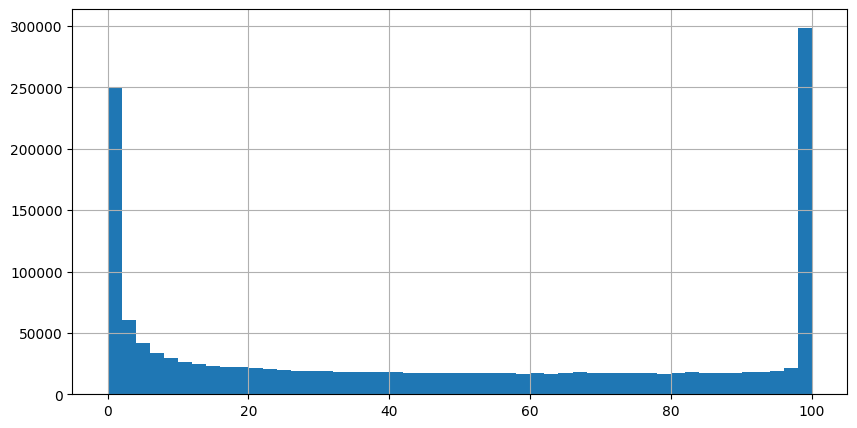

In [92]:
df['progress'].hist(bins=50, figsize=(10, 5));

Либо бросают быстро, либо дочитывают до конца

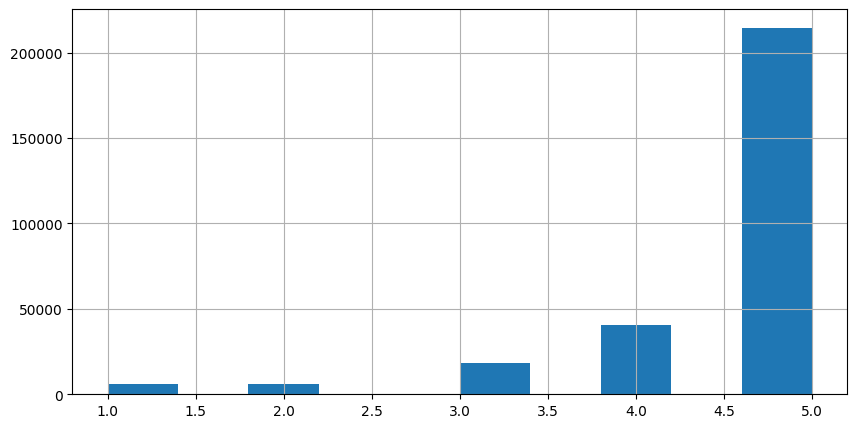

In [93]:
df['rating'].hist(bins=10, figsize=(10, 5));

Пользователи взаимодействуют с айтемами, которые им, скорее всего, понравятся, и предпочитают ставить оценки понравившимся, поэтому в реальных данных часто наблюдается смещение в сторону положительных оценок.

In [94]:
df['rating'].value_counts()

rating
5.0    214703
4.0     40382
3.0     18273
1.0      6115
2.0      5864
Name: count, dtype: int64

## Распределение числа прочтений у пользователя и книги

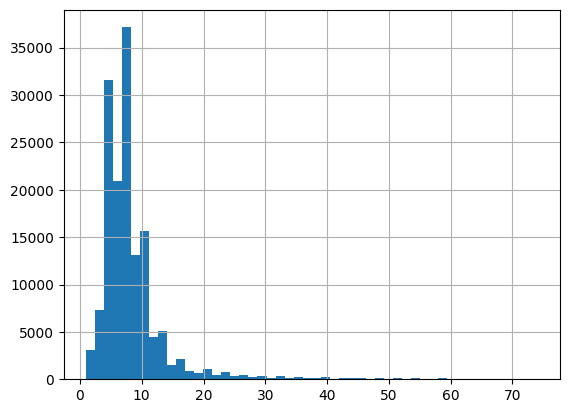

In [95]:
user_groups = df.groupby('user_id')['item_id'].count()
user_groups[user_groups < user_groups.quantile(0.99)].hist(bins=50);

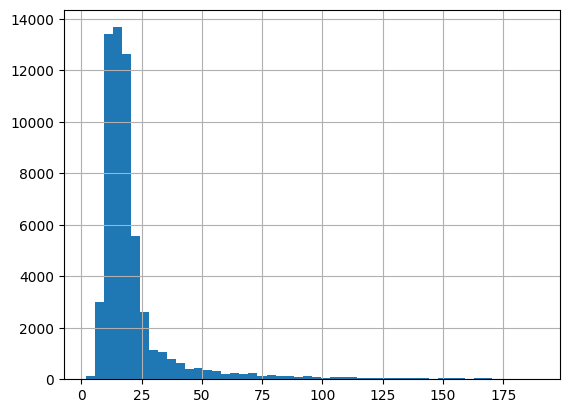

In [96]:
item_groups = df.groupby('item_id')['user_id'].count()
item_groups[item_groups < item_groups.quantile(0.99)].hist(bins=50);

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1532998 entries, 0 to 1533077
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   user_id     1532998 non-null  int64  
 1   item_id     1532998 non-null  int64  
 2   progress    1532998 non-null  int64  
 3   rating      285337 non-null   float64
 4   start_date  1532998 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 70.2+ MB


In [98]:
df_implicit = df.copy()
df_explicit = df.dropna()

# ALS

## Implicit

### Filter data

In [ ]:
def filter_data(df, user_count=10, item_count=10):
    item_counts = df.groupby(ITEM_COL)[USER_COL].count()
    pop_items = item_counts[item_counts > user_count]
    df_implicit = df[df[ITEM_COL].isin(pop_items.index)]

    user_counts = df.groupby(USER_COL)[ITEM_COL].count()
    pop_users = user_counts[user_counts > item_count]
    df = df[df[USER_COL].isin(pop_users.index)].copy()
    return df

Фильтруем пользователей, у которых меньше 10 прочитанных книг и книги, которые прочли менее 20 пользователей.

In [99]:
df_implicit = filter_data(df_implicit, user_count=10, item_count=20)
df_implicit.shape[0]

459065

### Train-test-split

На этот раз отделяем данные в тест по timestemp. Оценивать качество будем предсказывая последний айтем из теста.

In [100]:
def train_test_split(
    clickstream_df,
    test_quantile=0.9
):
    """
    Split clickstream by date.
    """
    clickstream_df = clickstream_df.sort_values([USER_COL, TIMESTAMP])
    test_timepoint = clickstream_df[TIMESTAMP].quantile(
    q=test_quantile, interpolation='nearest'
    )
    test = clickstream_df.query(f'{TIMESTAMP} >= @test_timepoint')
    train = clickstream_df.drop(test.index)

    test = test[test[USER_COL].isin(train[USER_COL])]
    test = test[test[ITEM_COL].isin(train[ITEM_COL])]

    test_full_history = test.sort_values([USER_COL, TIMESTAMP]).groupby(USER_COL)
    last_item = test_full_history.tail(1)
    test_history = test_full_history.head(-1)

    test = pd.concat([train, test_history])

    test.reset_index(drop=True, inplace=True)
    train.reset_index(drop=True, inplace=True)
    return train, test, last_item

In [101]:
train, test, last_item = train_test_split(df_implicit)

Оставим только понравившиеся книги.

In [102]:
last_item = last_item[last_item[IMP_RATING_COL] >= 10]

### Train model

In [103]:
def get_sparse_matrix(df, rating_col):
    rating = list(df[rating_col])

    rows = df[USER_COL].astype('category').cat.codes
    cols = df[ITEM_COL].astype('category').cat.codes

    df_sparse = sparse.csr_matrix((rating, (rows, cols)))
    return df_sparse, rows, cols

In [104]:
train_sparse, train_rows_imp, train_cols_imp = get_sparse_matrix(train, IMP_RATING_COL)

Посмотрим, насколько разрежена полученная матрица.

In [105]:
matrix_size = train_sparse.shape[0] * train_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(train_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100 * (1 - (num_purchases/matrix_size))
sparsity

99.91371114916436

In [106]:
algo = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=50, use_gpu=False)
algo.fit((train_sparse).astype('double'))

  0%|          | 0/50 [00:00<?, ?it/s]

In [107]:
user_vecs = algo.user_factors
item_vecs = algo.item_factors

print(train_sparse.shape)
print(user_vecs.shape, item_vecs.shape)

(7561, 51358)
(7561, 50) (51358, 50)


### Predict

$ \hat{R} = U_{d} V^{T}_{d}$

In [108]:
def get_scores(user_vecs, item_vecs, rating_matrix):
    scores = user_vecs.dot(item_vecs.T)
    scores = np.multiply(scores,
        np.invert(rating_matrix.astype(bool))
        )
    return scores

def predict(scores, rows, cols, k=10):
    id2user = dict(zip(rows, train.user_id))
    id2item = dict(zip(cols, train.item_id))

    ind_part = np.argpartition(scores, -k + 1)[:, -k:].copy()
    scores_not_sorted = np.take_along_axis(scores, ind_part, axis=1)
    ind_sorted = np.argsort(scores_not_sorted, axis=1)
    indices = np.take_along_axis(ind_part, ind_sorted, axis=1)
    preds = pd.DataFrame({
        USER_COL: range(scores.shape[0]),
        'preds': np.flip(indices, axis=1).tolist(),
        })
    preds[USER_COL] = preds[USER_COL].map(id2user)
    preds['preds'] = preds['preds'].map(lambda inds: [id2item[i] for i in inds])
    return preds

In [109]:
scores_imp = get_scores(user_vecs, item_vecs, train_sparse.todense())
pred_imp = predict(scores_imp, train_rows_imp, train_cols_imp)
pred_imp = pred_imp.merge(last_item, how='right', on='user_id')

In [110]:
def hr(df: pd.DataFrame, pred_col='preds', true_col='item_id') -> float:
    hr_values = []
    for _, row in df.iterrows():
      hr_values.append(int(row[true_col] in row[pred_col]))
    return round(np.mean(hr_values), 4)

In [111]:
hr(pred_imp)

0.0136

## Explicit

### Filter data

Фильтруем пользователей, которые поставили меньше 10 оценок и книги, у которых менее 10 оценок.

In [112]:
df_explicit = filter_data(df_explicit, user_count=10, item_count=10)
df_explicit.shape[0]

101373

### Train-test-split

Разделим данные и оставим только книги с высокими оценками.

In [113]:
train, test, last_item = train_test_split(df_explicit)
last_item = last_item[last_item[EXP_RATING_COL] >= 4]

### Train model

In [114]:
train_sparse, train_rows_exp, train_cols_exp = get_sparse_matrix(train, EXP_RATING_COL)

Посмотрим, насколько разрежена полученная матрица.

In [115]:
matrix_size = train_sparse.shape[0] * train_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(train_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100 * (1 - (num_purchases/matrix_size))
sparsity

99.79784166700252

In [116]:
algo = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=50, use_gpu=False)
algo.fit((train_sparse).astype('double'))

  0%|          | 0/50 [00:00<?, ?it/s]

In [117]:
user_vecs = algo.user_factors
item_vecs = algo.item_factors
# проверим по размерам, что мы действиельно не перепутали users и items
print(train_sparse.shape)
print(user_vecs.shape, item_vecs.shape)

(2514, 17943)
(2514, 50) (17943, 50)


### Predict

In [118]:
scores_exp = get_scores(user_vecs, item_vecs, train_sparse.todense())
pred_exp = predict(scores_exp, train_rows_exp, train_cols_exp)
pred_exp = pred_exp.merge(last_item, how='right', on='user_id')

In [119]:
hr(pred_exp)

0.0285

# Online prediction

$ \hat{R} = R V_{d} V^{T}_{d}$

In [120]:
test_sparse, test_rows_exp, test_cols_exp = get_sparse_matrix(test, EXP_RATING_COL)

In [121]:
def get_scores_new_actions(item_vecs, updated_rating_matrix):
    scores = updated_rating_matrix.dot(item_vecs) @ item_vecs.T
    scores = np.multiply(scores,
        np.invert(updated_rating_matrix.astype(bool))
        )
    return scores

In [122]:
scores_exp_updated = get_scores_new_actions(item_vecs, test_sparse.todense())
pred_exp_updated = predict(scores_exp_updated, test_rows_exp, test_cols_exp)
pred_exp_updated = pred_exp_updated.merge(last_item, how='right', on='user_id')

In [123]:
hr(pred_exp_updated)

0.0506

Проверим качество, используя только действия из трейна.

In [124]:
scores_exp = get_scores_new_actions(item_vecs, train_sparse.todense())
pred_exp = predict(scores_exp, train_rows_exp, train_cols_exp)
pred_exp = pred_exp.merge(last_item, how='right', on='user_id')

In [125]:
hr(pred_exp)

0.0272

## Предсказание для одного пользователя

In [126]:
items = pd.read_csv('items.csv')

In [127]:
id2item = dict(zip(test_cols_exp, test.item_id))

In [128]:
recommendations = algo.recommend(0, test_sparse[0])

In [129]:
recommendations

(array([14547, 10450,  2246,  1322,   124,  8297,  4866,  1238,  7814,
         7034], dtype=int32),
 array([0.12471227, 0.11544029, 0.11029245, 0.11006856, 0.10615963,
        0.10539725, 0.10444929, 0.10253426, 0.10239471, 0.1012171 ],
       dtype=float32))

In [130]:
pd.DataFrame([id2item[i] for i in recommendations[0]]).merge(items, left_on=0, right_on='id')

,0,id,title,genres,authors,year
0,261138,261138,Летос,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2014
1,187501,187501,Разрушитель божественных замыслов,"Героическое фэнтези,Попаданцы,Боевое фэнтези",Владимир Сухинин,2017
2,39765,39765,Первые сполохи войны,"Героическое фэнтези,Попаданцы,Боевое фэнтези",Владимир Сухинин,2018
3,23553,23553,Вся правда о нас,"Детективное фэнтези,Городское фэнтези,Книги пр...",Макс Фрай,2015
4,2028,2028,Скорпион Его Величества,"Героическое фэнтези,Попаданцы,Боевое фэнтези",Владимир Сухинин,2018
5,149503,149503,Чужак,"Детективное фэнтези,Городское фэнтези,Книги пр...",Макс Фрай,1996
6,88397,88397,Пешка в большой игре,"Героическое фэнтези,Попаданцы,Боевое фэнтези",Владимир Сухинин,2017
7,22066,22066,Заложник долга и чести,"Героическое фэнтези,Попаданцы,Боевое фэнтези",Владимир Сухинин,2018
8,140991,140991,Лабиринт Мёнина (сборник),"Детективное фэнтези,Героическое фэнтези,Городс...",Макс Фрай,2000
9,126214,126214,Взять живым мёртвого,"Детективное фэнтези,Героическое фэнтези,Попада...",Андрей Белянин,2017


In [131]:
user_history = test[test[USER_COL] == 21][[ITEM_COL]] # user idx=0, id=21
user_history.merge(items, left_on='item_id', right_on='id')

,item_id,id,title,genres,authors,year
0,193711,193711,История Бернарды и Тайры на Архане,"Любовно-фантастические романы,Научная фантасти...",Вероника Мелан,2015
1,32399,32399,Спектр,"Социальная фантастика,Космическая фантастика,Н...",Сергей Лукьяненко,2001-02
2,155015,155015,Выиграть жизнь. Сказки из сундука,"Этнография,Книги о путешествиях",Виталий Сундаков,2018
3,121640,121640,Золотые костры,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2012
4,136668,136668,Синее пламя,"Героическое фэнтези,Боевое фэнтези,Книги про в...",Алексей Пехов,2015
5,11951,11951,Талорис,"Героическое фэнтези,Боевое фэнтези,Книги про в...",Алексей Пехов,2019
6,204089,204089,Змейка,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2005
7,128170,128170,Инстинкт зла. Тень,"Эротическое фэнтези,Городское фэнтези,Любовное...",Марина Суржевская,2017
8,31873,31873,Инстинкт Зла. Вершитель,"Эротическое фэнтези,Городское фэнтези,Любовное...",Марина Суржевская,2016
9,131575,131575,Инстинкт Зла. Возрожденная,"Эротическое фэнтези,Городское фэнтези,Любовное...",Марина Суржевская,2016
